In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten,BatchNormalization,MaxPool2D,GlobalAveragePooling2D,Activation
import tensorflow_addons as tfa
from keras_visualizer import visualizer 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  rotation_range=3,
        width_shift_range=0.4,
        height_shift_range=0.78,
        shear_range=0.12,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
TRAIN_VAL_DIR = './dataset/train/'
TEST_DIR='./dataset/test/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMAGE_SIZE = [176, 176]


In [4]:
import os
files={k:0 for k in CLASSES}
for f in os.listdir("./dataset/train"):
    for k in os.listdir("./dataset/train/"+f):
        files[f]+=1

<BarContainer object of 4 artists>

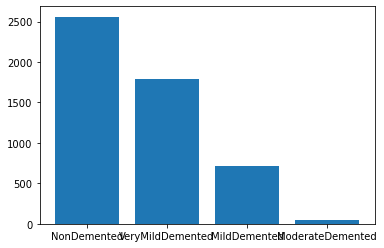

In [5]:
plt.bar(files.keys(),files.values())

#### Model creation functions

In [6]:
def conv_block(filters, act='relu'):
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block
def dense_block(units, dropout_rate, act='relu',kernel=None):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    return model


In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                   target_size = tuple(IMAGE_SIZE),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 16)
valid_dataset = valid_datagen.flow_from_directory(directory = TRAIN_VAL_DIR,
                                                  target_size = tuple(IMAGE_SIZE),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 16)
test_dataset = test_datagen.flow_from_directory(directory = TEST_DIR,
                                                  target_size = tuple(IMAGE_SIZE),
                                                  class_mode = 'categorical',
                                                  batch_size = 16)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [8]:
len(next(train_dataset)[0])

16

In [9]:
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_my_cnn_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

### Model creations

In [10]:
model = construct_model()

METRICS = [tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [rop_callback,early_stopping_cb,checkpoint_cb]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                      

In [42]:
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
my_model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 35,
                         callbacks=CALLBACKS)

Epoch 1/35
257/257 [==============================] - 219s 825ms/step - loss: 1.5784 - auc: 0.6338 - val_loss: 1.2287 - val_auc: 0.6647 - lr: 0.0010
Epoch 2/35
257/257 [==============================] - 187s 726ms/step - loss: 1.1963 - auc: 0.7494 - val_loss: 0.9873 - val_auc: 0.8143 - lr: 0.0010
Epoch 3/35
257/257 [==============================] - 183s 710ms/step - loss: 1.0729 - auc: 0.7854 - val_loss: 8.1629 - val_auc: 0.6688 - lr: 0.0010
Epoch 4/35
257/257 [==============================] - 183s 712ms/step - loss: 1.0148 - auc: 0.8017 - val_loss: 1.3888 - val_auc: 0.6138 - lr: 0.0010
Epoch 5/35
257/257 [==============================] - 182s 707ms/step - loss: 0.9853 - auc: 0.8098 - val_loss: 1.2198 - val_auc: 0.6262 - lr: 0.0010
Epoch 6/35
257/257 [==============================] - 180s 700ms/step - loss: 0.9644 - auc: 0.8141 - val_loss: 1.0684 - val_auc: 0.7613 - lr: 1.0000e-04
Epoch 7/35
257/257 [==============================] - 177s 688ms/step - loss: 0.9534 - auc: 0.8195 - v

In [43]:
model.save("./my_model")

INFO:tensorflow:Assets written to: ./my_model/assets


In [52]:
model.evaluate(test_dataset)

80/80 [==============================] - 27s 336ms/step - loss: 0.9129 - auc: 0.8369


[0.9129173755645752, 0.8368504643440247]

### RESNET Model

In [54]:
base_model = ResNet50(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")


In [55]:
for layer in base_model.layers:
    layer.trainable=False

In [70]:
res_model=Sequential()
res_model.add(base_model)
res_model.add(Dropout(0.5))
res_model.add(Flatten())
res_model.add(BatchNormalization())
res_model.add(Activation('relu'))
res_model.add(Dropout(0.5))
res_model.add(Dense(4,activation='softmax'))



In [72]:
METRICS = [
           tf.keras.metrics.AUC(name='auc')
           ]

CALLBACKS = [rop_callback,early_stopping_cb,checkpoint_cb]

res_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)
res_history=res_model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 35,
                        verbose = 1,
                         callbacks=CALLBACKS)

Epoch 1/35


In [61]:
res_model.save('./resnet_model')

INFO:tensorflow:Assets written to: ./resnet_model/assets


/home/jayaram/miniconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/jayaram/miniconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Inception Model

In [74]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [75]:
# Using the pretrained model
for layer in inception_model.layers:
    layer.trainable=False

In [76]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [78]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [lr_scheduler, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout_35 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_232 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 512)       

In [79]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 9

inception_net_history = custom_inception_model.fit(train_dataset, validation_data=valid_dataset, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/9
129/129 [==============================] - 115s 856ms/step - loss: 1.1059 - acc: 0.4915 - auc: 0.7795 - f1_score: 0.3077 - val_loss: 1.2011 - val_acc: 0.5103 - val_auc: 0.8112 - val_f1_score: 0.3191 - lr: 0.0100
Epoch 2/9
129/129 [==============================] - 137s 1s/step - loss: 0.9592 - acc: 0.5246 - auc: 0.8214 - f1_score: 0.3028 - val_loss: 1.0590 - val_acc: 0.4516 - val_auc: 0.7951 - val_f1_score: 0.2393 - lr: 0.0063
Epoch 3/9
129/129 [==============================] - 113s 871ms/step - loss: 0.9292 - acc: 0.5576 - auc: 0.8361 - f1_score: 0.3371 - val_loss: 1.0601 - val_acc: 0.4712 - val_auc: 0.7878 - val_f1_score: 0.2427 - lr: 0.0040
Epoch 4/9
129/129 [==============================] - 105s 816ms/step - loss: 0.9112 - acc: 0.5688 - auc: 0.8429 - f1_score: 0.3465 - val_loss: 1.0461 - val_acc: 0.4878 - val_auc: 0.7832 - val_f1_score: 0.2710 - lr: 0.0025
Epoch 5/9
129/129 [==============================] - 106s 819ms/step - loss: 0.8957 - acc: 0.5793 - auc: 0.8491 - f

In [80]:
inception_model.save('inception_model')

INFO:tensorflow:Assets written to: inception_model/assets


### My CNN model plots

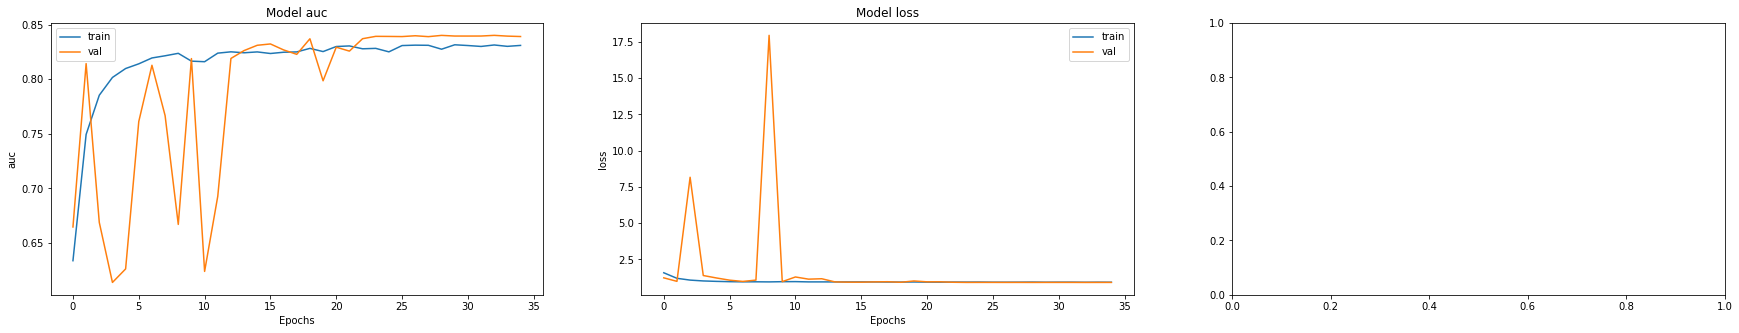

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["auc", "loss"]):
    ax[i].plot(my_model_history.history[metric])
    ax[i].plot(my_model_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [60]:
scores = model.evaluate(test_dataset,return_dict=True)
print(scores)

80/80 [==============================] - 23s 275ms/step - loss: 0.9129 - auc: 0.8369
{'loss': 0.9129176735877991, 'auc': 0.8368504643440247}


In [62]:
scores2=res_model.evaluate(test_dataset,return_dict=True)
print(scores2)

80/80 [==============================] - 50s 615ms/step - loss: 1.0007 - auc: 0.8041
{'loss': 1.0006682872772217, 'auc': 0.8041108846664429}


### resnet model plots

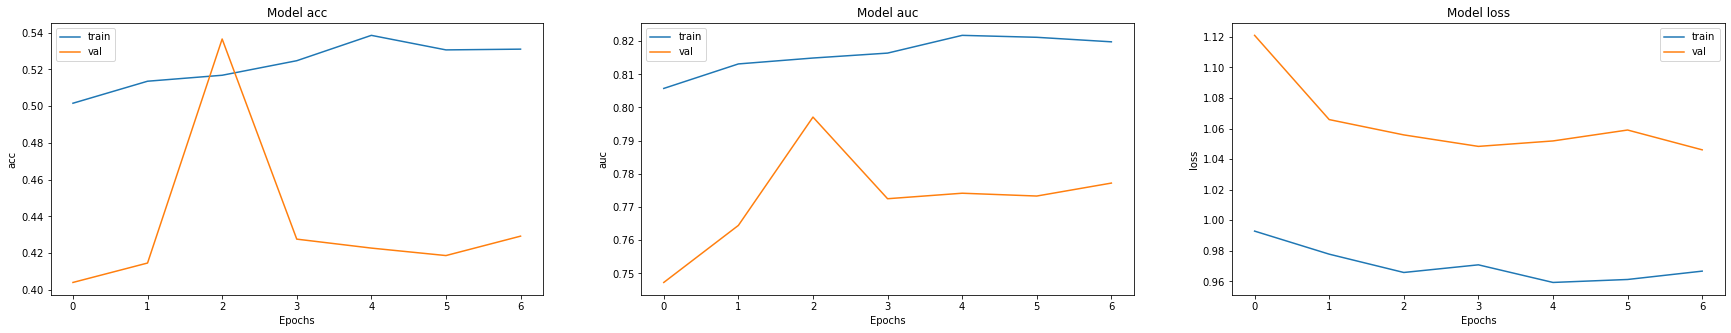

In [48]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(res_history.history[metric])
    ax[i].plot(res_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### inceptionnet model plots

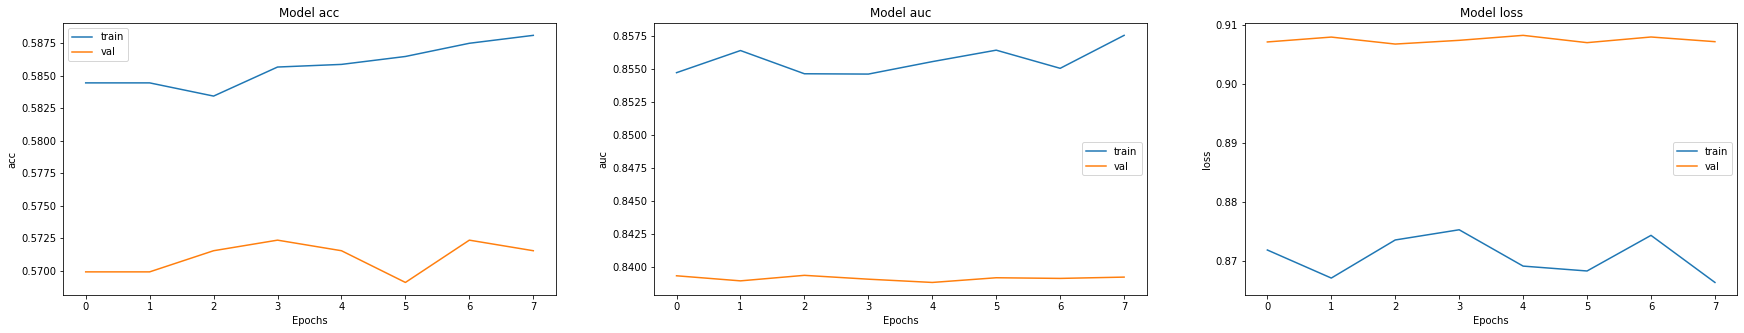

In [47]:

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(inception_net_history.history[metric])
    ax[i].plot(inception_net_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])